In [1]:
import pystac_client
from odc import stac as odc_stac
from dask.distributed import wait
from dask.distributed import Client, wait
import os
import xarray as xr
import pyproj
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import rioxarray
import hvplot.xarray

### Load the data

In [2]:
# set up dask client for paralelized computation
client = Client(processes=False, threads_per_worker=2, n_workers=3, memory_limit="12GB")

# Connect to STAC catalog
eodc_catalog = pystac_client.Client.open("https://stac.eodc.eu/api/v1/")

2025-10-15 16:58:36,545 - distributed.scheduler - WARNING - Worker failed to heartbeat for 728s; removing: <WorkerState 'inproc://192.168.1.8/17516/4', name: 0, status: running, memory: 23, processing: 0>
2025-10-15 16:58:36,561 - distributed.scheduler - WARNING - Worker failed to heartbeat for 728s; removing: <WorkerState 'inproc://192.168.1.8/17516/6', name: 1, status: running, memory: 21, processing: 0>
2025-10-15 16:58:36,561 - distributed.scheduler - WARNING - Worker failed to heartbeat for 728s; removing: <WorkerState 'inproc://192.168.1.8/17516/8', name: 2, status: running, memory: 20, processing: 0>
2025-10-15 16:58:36,561 - distributed.scheduler - WARNING - Workers ['inproc://192.168.1.8/17516/8', 'inproc://192.168.1.8/17516/4', 'inproc://192.168.1.8/17516/6'] do not use a nanny and will be terminated without restarting them
2025-10-15 16:58:36,561 - distributed.scheduler - WARNING - Removing worker 'inproc://192.168.1.8/17516/8' caused the cluster to lose already computed tas

In [3]:
# we define the time range of the event and coordinates of the area with the bounding_box
time_range = "2018-02-28/2018-02-28"
minlon, maxlon = 22.0, 22.8  
minlat, maxlat = 39.45, 39.75

bounding_box = [minlon, minlat, maxlon, maxlat]

In [4]:
# inside the EODC catalogue we get the GFM collection (Global Flood Monitoring) https://services.eodc.eu/browser/#/v1/collections/GFM?.language=en
search = eodc_catalog.search(collections="GFM", bbox=bounding_box, datetime=time_range)
items_GFM = search.item_collection()

items_GFM[0].properties

{'gsd': 20,
 'created': '2024-10-29T13:09:01.227757+00:00',
 'datetime': '2018-02-28T16:32:02Z',
 'Equi7Tile': 'EU020M_E054N006T3',
 'blocksize': {'x': 512, 'y': 512},
 'proj:bbox': [5400000, 600000, 5700000, 900000],
 'proj:wkt2': 'PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]',
 'proj:shape': [15000, 15000],
 'constellation': 'sentinel-1',
 'flood_members': {'DLR': True, 'TUW': True, 'LIST': True},
 'proj:geometry': {'type': 'Polygon',
  'coordinates': [[[5400000.0, 600000.0],
    [5400000.0, 900000.0],
    [5700000.0, 900000.0],
    [5700000.0, 600000.0],
    [540000

In [5]:
crs = pyproj.CRS.from_wkt(items_GFM[0].properties["proj:wkt2"])

# Set the resolution of the data
resolution = items_GFM[0].properties['gsd']

GFM_dc= odc_stac.load(
    items_GFM, 
    bbox=bounding_box,   # Define the bounding box for the area of interest
    crs=crs,   # Set the coordinate reference system
    #bands=["tuw_likelihood","tuw_flood_extent"],   # Specify the bands to load, comment to load all bands
    resolution=resolution,   # Set the resolution of the data
    dtype='uint8',   # Define the data type
    chunks={"x": 1000, "y": 1000, "time": -1},  # Set the chunk size for Dask
)

GFM_dc = GFM_dc.persist()
wait(GFM_dc)

GFM_dc

<xarray.Dataset> Size: 438MB
Dimensions:                (y: 1739, x: 3500, time: 6)
Coordinates:
  * y                      (y) float64 14kB 6.508e+05 6.508e+05 ... 6.161e+05
  * x                      (x) float64 28kB 5.664e+06 5.664e+06 ... 5.734e+06
  * time                   (time) datetime64[ns] 48B 2018-02-28T04:38:43 ... ...
    spatial_ref            int32 4B 27704
Data variables:
    advisory_flags         (time, y, x) uint8 37MB dask.array<chunksize=(6, 1000, 1000), meta=np.ndarray>
    dlr_likelihood         (time, y, x) uint8 37MB dask.array<chunksize=(6, 1000, 1000), meta=np.ndarray>
    exclusion_mask         (time, y, x) uint8 37MB dask.array<chunksize=(6, 1000, 1000), meta=np.ndarray>
    tuw_likelihood         (time, y, x) uint8 37MB dask.array<chunksize=(6, 1000, 1000), meta=np.ndarray>
    list_likelihood        (time, y, x) uint8 37MB dask.array<chunksize=(6, 1000, 1000), meta=np.ndarray>
    dlr_flood_extent       (time, y, x) uint8 37MB dask.array<chunksize=(6, 1000, 1000), meta=np.ndarray>
    tuw_flood_extent       (time, y, x) uint8 37MB dask.array<chunksize=(6, 1000, 1000), meta=np.ndarray>
    list_flood_extent      (time, y, x) uint8 37MB dask.array<chunksize=(6, 1000, 1000), meta=np.ndarray>
    ensemble_likelihood    (time, y, x) uint8 37MB dask.array<chunksize=(6, 1000, 1000), meta=np.ndarray>
    reference_water_mask   (time, y, x) uint8 37MB dask.array<chunksize=(6, 1000, 1000), meta=np.ndarray>
    ensemble_flood_extent  (time, y, x) uint8 37MB dask.array<chunksize=(6, 1000, 1000), meta=np.ndarray>
    ensemble_water_extent  (time, y, x) uint8 37MB dask.array<chunksize=(6, 1000, 1000), meta=np.ndarray>

In [ ]:
# Pre-processing
# Substitute 255 for NaNs
GFM_dc["tuw_flood_extent"] = GFM_dc.tuw_flood_extent.where(GFM_dc.tuw_flood_extent!=255).compute()
GFM_dc["tuw_likelihood"] = GFM_dc.tuw_likelihood.where(GFM_dc.tuw_likelihood!=255).compute()
GFM_dc["reference_water_mask"] = GFM_dc.reference_water_mask.where(GFM_dc.reference_water_mask!=255).compute()
GFM_dc["exclusion_mask"] = GFM_dc.exclusion_mask.where(GFM_dc.exclusion_mask!=255).compute()

In [7]:
cube = GFM_dc

In [9]:
# Access the variables
tuw_likelihood = cube["tuw_likelihood"]
tuw_flood_extent = cube["tuw_flood_extent"]

tuw_likelihood = tuw_likelihood.isel(time=1)
tuw_flood_extent = tuw_flood_extent.isel(time=1)
reference_water_mask = cube["reference_water_mask"].isel(time=1)
exclusion_mask = cube["exclusion_mask"].isel(time=1)


In [10]:
num_flooded = np.sum(tuw_flood_extent.values > 0)
num_total = tuw_flood_extent.size
print(f"Flooded fraction: {num_flooded / num_total:.2%}")

Flooded fraction: 1.56%


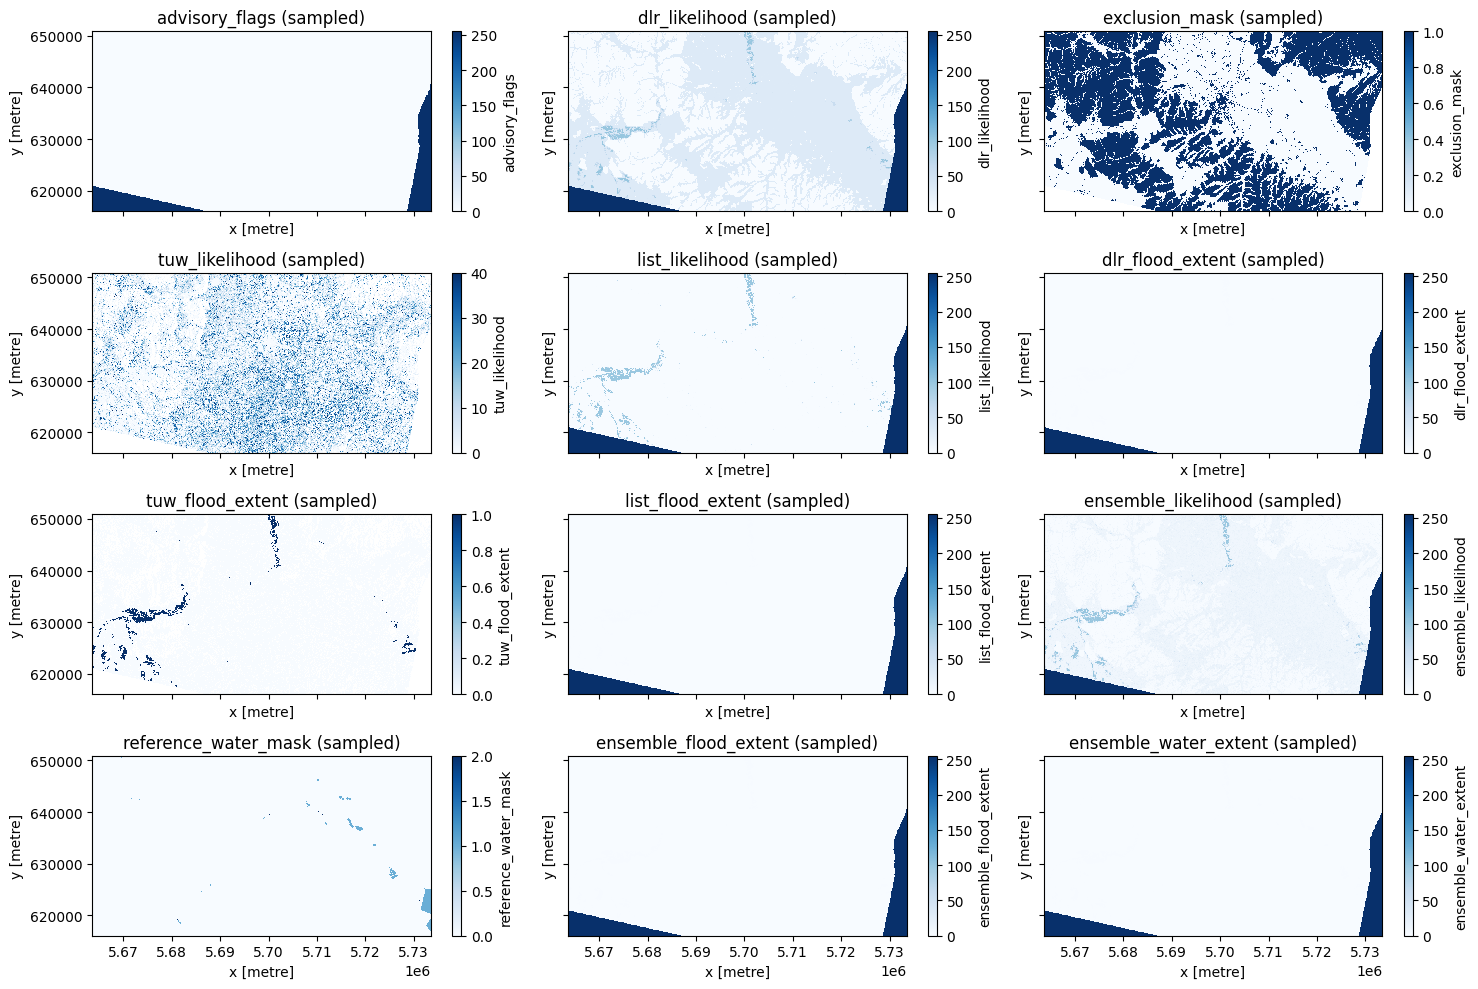

In [11]:
# Option 1: Sample every nth pixel for faster plotting
fig, ax = plt.subplots(4, 3, figsize=(15, 10), sharey=True, sharex=True)
band_names = list(cube.data_vars.keys())  # First 3 bands only

for i, band_name in enumerate(band_names):
    sampled_data = cube[band_name][1, ::4, ::4]
    col = i % 3
    row = i // 3
    sampled_data.plot(ax=ax[row, col], cmap='Blues')
    ax[row, col].set_title(f'{band_name} (sampled)')

plt.tight_layout()
plt.show()

In [26]:
reference_water_mask.hvplot.image(title="Flood Likelihood", cmap="Blues", colorbar=True)

:Image   [x,y]   (reference_water_mask)

In [33]:

tuw_likelihood.hvplot.image(title="Flood Likelihood", cmap="Blues", colorbar=True) + \
tuw_flood_extent.hvplot.image(title="Observed Flood Extent", cmap="Reds", colorbar=True)


:Layout
   .Image.I  :Image   [x,y]   (tuw_likelihood)
   .Image.II :Image   [x,y]   (tuw_flood_extent)

In [14]:
da = tuw_flood_extent.copy()  # DO NOT select da.y or da.x

# Step 2: Set spatial dimensions
da = da.rio.set_spatial_dims(x_dim='x', y_dim='y')

In [15]:
ae_crs = (
    "+proj=aeqd +lat_0=53 +lon_0=24 "
    "+x_0=5837287.81977 +y_0=2121415.69617 "
    "+datum=WGS84 +units=m +no_defs"
)
da = da.rio.write_crs(ae_crs)

# Step 4: Reproject to WGS84 (lon/lat)
da_ll = da.rio.reproject("EPSG:4326")

# Step 5: Clip to your bounding box
minlon, maxlon = 22.0, 22.8
minlat, maxlat = 39.45, 39.75
da_ll_clipped = da_ll.rio.clip_box(minx=minlon, maxx=maxlon, miny=minlat, maxy=maxlat)

 

da_visible = da_ll_clipped.where(da_ll_clipped == 1)
da_visible.hvplot.image(
    x="x", y="y",
    geo=True,
    tiles="OSM",
    cmap=["darkred"],
    alpha=0.75,
    frame_height=450,
    title="Flood Extent on Map",
    colorbar=False
)


:Overlay
   .WMTS.I  :WMTS   [Longitude,Latitude]
   .Image.I :Image   [x,y]   (tuw_flood_extent)

### Germany Map TEST

In [41]:
# we define the time range of the event and coordinates of the area with the bounding_box
time_range = "2022-10-11/2022-10-25"
time_range = "2023-10-19/2023-10-21"
minlon, maxlon = 12.3, 13.1
minlat, maxlat = 54.3, 54.6
bounding_box = [minlon, minlat, maxlon, maxlat]

In [42]:
# inside the EODC catalogue we get the GFM collection (Global Flood Monitoring) https://services.eodc.eu/browser/#/v1/collections/GFM?.language=en
search = eodc_catalog.search(collections="GFM", bbox=bounding_box, datetime=time_range)
items_GFM = search.item_collection()

print(f"Found {len(items_GFM)} items") 

Found 3 items


In [43]:
crs = pyproj.CRS.from_wkt(items_GFM[0].properties["proj:wkt2"])

# Set the resolution of the data
resolution = items_GFM[0].properties['gsd']

german_dc= odc_stac.load(
    items_GFM, 
    bbox=bounding_box,   # Define the bounding box for the area of interest
    crs=crs,   # Set the coordinate reference system
    #bands=["tuw_likelihood","tuw_flood_extent"],   # Specify the bands to load, comment to load all bands
    resolution=resolution,   # Set the resolution of the data
    dtype='uint8',   # Define the data type
    chunks={"x": 1000, "y": 1000, "time": -1},  # Set the chunk size for Dask
)

german_dc = german_dc.persist()
wait(german_dc)

german_dc

KeyboardInterrupt: 

In [ ]:
german_dc["tuw_flood_extent"] = german_dc.tuw_flood_extent.where(german_dc.tuw_flood_extent!=255).compute()
german_dc["tuw_likelihood"] = german_dc.tuw_likelihood.where(german_dc.tuw_likelihood!=255).compute()


### Greece color Test

In [32]:
import hvplot.xarray
import rioxarray

# Full 2D arrays
flood = tuw_flood_extent.copy()
likelihood = tuw_likelihood.copy()

# Make sure spatial dims are recognized
flood = flood.rio.set_spatial_dims(x_dim='x', y_dim='y')
likelihood = likelihood.rio.set_spatial_dims(x_dim='x', y_dim='y')

# Assign CRS (same for both)
ae_crs = "+proj=aeqd +lat_0=53 +lon_0=24 +x_0=5837287.81977 +y_0=2121415.69617 +datum=WGS84 +units=m +no_defs"
flood = flood.rio.write_crs(ae_crs)
likelihood = likelihood.rio.write_crs(ae_crs)

# Reproject to WGS84
flood_ll = flood.rio.reproject("EPSG:4326")
likelihood_ll = likelihood.rio.reproject("EPSG:4326")


In [99]:
minlon, maxlon = 22.0, 22.8
minlat, maxlat = 39.45, 39.75

flood_ll = flood_ll.rio.clip_box(minx=minlon, maxx=maxlon, miny=minlat, maxy=maxlat)
likelihood_ll = likelihood_ll.rio.clip_box(minx=minlon, maxx=maxlon, miny=minlat, maxy=maxlat)


In [34]:
# Flood extent (base layer)
flood_plot = flood_ll.hvplot.image(
    x='x', y='y',
    geo=True,
    cmap=["lightgray", "darkred"],  # 0=gray, 1=flood=red
    alpha=0.6,
    colorbar=False,
    frame_height=450,
)

# Likelihood (overlay)
likelihood_plot = likelihood_ll.hvplot.image(
    x='x', y='y',
    geo=True,
    cmap="viridis",
    alpha=0.5,
    colorbar=True,
)

# Combine layers
combined = flood_plot * likelihood_plot
combined.opts(title="Flood Extent and Likelihood")


NameError: name 'flood_ll' is not defined